In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import kagglehub
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage

# 1. Gathering Data from Kaggle

In [2]:
# Download the latest version of the dataset.
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")

100%|██████████| 159M/159M [00:02<00:00, 74.2MB/s]

Extracting files...


In [3]:
# Identify the paths to the desired data.
postings_path = path + "/postings.csv"
benefits_path = path + "/jobs/benefits.csv"
industries_path = path + "/jobs/job_industries.csv"
skills_path = path + "/jobs/job_skills.csv"
salaries_path = path + "/jobs/salaries.csv"

In [4]:
# Read the data into dataframes.
df_postings = pd.read_csv(postings_path)        # Data on job listings.
df_benefits = pd.read_csv(benefits_path)        # Data on job benefits.
df_industries = pd.read_csv(industries_path)    # Data on job industries.
df_skills = pd.read_csv(skills_path)            # Data on job skills.
df_salaries = pd.read_csv(salaries_path)        # Data on job salaries.

# 2 - Pandas Data Review

This section performs a systematic data review for the project datasets that were loaded earlier.

Steps included:
- Show shapes (rows, columns) for each DataFrame loaded
- Display column names and dtypes
- Show summary statistics with .describe()
- List unique values / top counts for categorical columns
- Plot histograms and boxplots for numeric distributions
- Per-feature summary (value_counts or describe)
- Correlation heatmap for numeric features


### Show DataFrame Shapes

In [5]:
# Print shape (rows, cols) for each dataframe
# Print the shape of postings
print('df_postings shape:', df_postings.shape)
print('df_benefits shape:', df_benefits.shape)
print('df_industries shape:', df_industries.shape)
print('df_skills shape:', df_skills.shape)
print('df_salaries shape:', df_salaries.shape)

df_postings shape: (123849, 31)
df_benefits shape: (67943, 3)
df_industries shape: (164808, 2)
df_skills shape: (213768, 2)
df_salaries shape: (40785, 8)


### Display Column Names and dTypes


In [6]:
# Show column names and data types for main dataframe (postings)
print('\nColumns and dtypes for df_postings:')
df_postings.dtypes


Columns and dtypes for df_postings:


,0
job_id,int64
company_name,object
title,object
description,object
max_salary,float64
pay_period,object
location,object
company_id,float64
views,float64
med_salary,float64


### Summarize DataFrames with describe()

In [7]:
# Quick summary statistics
print('\nNumeric summary (describe) for df_postings:')
df_postings.select_dtypes(include=[np.number]).describe().T

print('\nAll columns summary (describe include=all) - note: object columns will show counts/unique/top/freq:')
df_postings.describe(include='all').T


Numeric summary (describe) for df_postings:

All columns summary (describe include=all) - note: object columns will show counts/unique/top/freq:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
job_id,123849.0,NaN,NaN,NaN,3896402138.074615,84043545.161881,921716.0,3894586595.0,3901998406.0,3904707077.0,3906267224.0
company_name,122130,24428,Liberty Healthcare and Rehabilitation Services,1108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,123849,72521,Sales Manager,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,123842,107827,Position Summary: Our Sales Manager has managi...,474,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_salary,29793.0,NaN,NaN,NaN,91939.423461,701110.138622,1.0,48.28,80000.0,140000.0,120000000.0
pay_period,36073,5,YEARLY,20628,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,123849,8526,United States,8125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_id,122132.0,NaN,NaN,NaN,12204012.335015,25541431.65742,1009.0,14352.0,226965.0,8047188.0,103472979.0
views,122160.0,NaN,NaN,NaN,14.618247,85.903598,1.0,3.0,4.0,8.0,9975.0
med_salary,6280.0,NaN,NaN,NaN,22015.619876,52255.873846,0.0,18.94,25.5,2510.5,750000.0


### List Unique Values and Counts

In [8]:
# Unique values and top value counts for categorical columns in df_postings
cat_cols = df_postings.select_dtypes(include=['object','category']).columns.tolist()
print('Categorical columns found:', cat_cols)

for c in cat_cols:
    print('\n===', c, '===')
    try:
        vc = df_postings[c].value_counts(dropna=False)
        print('unique values:', df_postings[c].nunique(dropna=False))
        display(vc.head(10))
    except Exception as e:
        print('Could not compute value_counts for', c, "->", e)

Categorical columns found: ['company_name', 'title', 'description', 'pay_period', 'location', 'formatted_work_type', 'job_posting_url', 'application_url', 'application_type', 'formatted_experience_level', 'skills_desc', 'posting_domain', 'work_type', 'currency', 'compensation_type']

=== company_name ===
unique values: 24429


,count
company_name,
NaN,1719
Liberty Healthcare and Rehabilitation Services,1108
The Job Network,1003
J. Galt,604
TEKsystems,529
"Lowe's Companies, Inc.",527
Ingersoll Rand,517
Capital One,496
Cogent Communications,476



=== title ===
unique values: 72521


,count
title,
Sales Manager,673
Customer Service Representative,373
Project Manager,354
Administrative Assistant,254
Senior Accountant,238
Executive Assistant,228
Salesperson,211
Registered Nurse,210
Receptionist,204



=== description ===
unique values: 107828


description
Position Summary: Our Sales Manager has managing partnerresponsibilities for a team of 5-25 Executive Consultants in marketing J.Galt's SaaS memberships and consulting services. In addition, the ManagingPartner/Sales Manager represents J. Galt in attracting memberships throughchannel partners, strategic alliances, chambers of commerce, and state,trade, and professional associations.\nOur Mission: We believe in helping small and medium-sized businessessucceed. It is tragic that most business owners carry the credit needs oftheir business. They often rely on personal credit cards, or they signpersonally for the business to access the funding, equipment, or facilities thebusiness requires to operate.\nWhat We Do: J. Galt Finance Suite offers a SaaS platform and consultativeservices to small and medium-sized business owners. Our system includes aproven 7-step process to build credit for a business around the business EINwithout personal guarantees or using the owner’s personal credit profile.\nJ. Galt is seeking six-figure sales talent and aggressive growth-orientedexecutives with a proven track record of success. Successful candidates willpossess a(n):\n• Minimum 10 years of successful business experience in a marketing-intensive business• Uncompromising need for top-level earnings• High energy, self-disciplined, self-starter with a positive attitude• Goal-oriented with a lifelong quest for personal development and career growth• Persuasive communication skills in oral & written form• Comfortable speaking in front of groups in person or virtually• Top-notch consultative sales skills• Comfortable marketing to professionals and C-level executives• Superior time management and organization skills and a desire to work from a home-based office• Professional appearance and demeanor• Passion to market a SaaS product that solves a small business owner's most vexing problem\nWhy J. Galt? | What We Offer• 1st-year Earnings Expectations of $125k-$175k• Long-term Earnings Expectations of $350k+• Weekly Personal Production Earnings• Weekly Override Team Production Earnings• $7,500 Quick Start Bonus after 90 Days.• $5,000 Monthly Personal Performance Bonus• $5,000 Monthly Business Unit Performance Bonus• 5-Figure Quarterly and 6-Figure Annual Bonus Opportunities for Top Producers• Substantial opportunity for promotion and career advancement• Additional earnings from cross-promotion strategies with sister companies in the cost-reduction consulting space\nPromotion Opportunities: Chief Revenue Officer | Equity Stakeholder\nMain Duties & ResponsibilitiesThe Managing Partner contributes significantly to personal production,key channel relationships, as well as hiring, training, and developing ateam of 5-25 Executive Consultants. In summation, a Managing Partnerhas complete control of a J. Galt business credit consulting practice.\nResponsibilities Include:• Attracting memberships through channel partners• Forming strategic alliances with state, trade, and professional associations• Forming partnerships with chambers of commerce• In-person and virtual presentations• Delivering business credit seminars to groups of 5-50 business owners• Monitoring and improving the sales performance of direct reports• Developing sales strategies• Managing the sales process through the J. Galt Sales App• Leading team meetings• Meeting monthly, quarterly, and annual sales targets                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            


=== pay_period ===
unique values: 6


,count
pay_period,
NaN,87776
YEARLY,20628
HOURLY,14741
MONTHLY,518
WEEKLY,177
BIWEEKLY,9



=== location ===
unique values: 8526


,count
location,
United States,8125
"New York, NY",2756
"Chicago, IL",1834
"Houston, TX",1762
"Dallas, TX",1383
"Atlanta, GA",1363
"Boston, MA",1176
"Austin, TX",1083
"Charlotte, NC",1075



=== formatted_work_type ===
unique values: 7


,count
formatted_work_type,
Full-time,98814
Contract,12117
Part-time,9696
Temporary,1190
Internship,983
Volunteer,562
Other,487



=== job_posting_url ===
unique values: 123849


,count
job_posting_url,
https://www.linkedin.com/jobs/view/3906267224/?trk=jobs_biz_prem_srch,1
https://www.linkedin.com/jobs/view/921716/?trk=jobs_biz_prem_srch,1
https://www.linkedin.com/jobs/view/1829192/?trk=jobs_biz_prem_srch,1
https://www.linkedin.com/jobs/view/10998357/?trk=jobs_biz_prem_srch,1
https://www.linkedin.com/jobs/view/23221523/?trk=jobs_biz_prem_srch,1
https://www.linkedin.com/jobs/view/35982263/?trk=jobs_biz_prem_srch,1
https://www.linkedin.com/jobs/view/91700727/?trk=jobs_biz_prem_srch,1
https://www.linkedin.com/jobs/view/103254301/?trk=jobs_biz_prem_srch,1
https://www.linkedin.com/jobs/view/112576855/?trk=jobs_biz_prem_srch,1



=== application_url ===
unique values: 84801


,count
application_url,
NaN,36665
https://app.dataannotation.tech/worker_signup?projects=PROG_SA&worker_src=L&utm_medium=display&utm_source=linkedin&utm_campaign=softwaredeveloper,205
https://revature.com/jobs/entry-level-automotive-engineer/?utm_source=linkedin&sourcedBy=BalaLP,67
https://app.dataannotation.tech/worker_signup?worker_src=LI&utm_medium=display&utm_source=linkedin&utm_campaign=aicontentwriter,60
https://www.english1.com/apply-now/?utm_source=linkedin&utm_medium=listing&utm_term=china&utm_content=linkedin&utm_campaign=linkedin,44
https://optimabiosupply.com/job-opening-data-entry-clerk/,43
https://dataforcecommunity.transperfect.com/project/amethyst-project-us?/fill?id313=DF017&id315=DavidS,18
https://forms.gle/Lj3M5Jhm2xWtZa1h6,17
https://forms.office.com/r/UAVrY128aW,15



=== application_type ===
unique values: 4


,count
application_type,
OffsiteApply,84607
ComplexOnsiteApply,31049
SimpleOnsiteApply,8192
UnknownApply,1



=== formatted_experience_level ===
unique values: 7


,count
formatted_experience_level,
Mid-Senior level,41489
Entry level,36708
NaN,29409
Associate,9826
Director,3746
Internship,1449
Executive,1222



=== skills_desc ===
unique values: 2213


,count
skills_desc,
NaN,121410
"This position requires the following skills: Elder care, Healthcare, Hospice Care, Patient Care",28
"This position requires the following skills: Advocacy, Community Outreach, CSR / Volunteer Coordination, Fundraising, Lobbying, Public Relations",19
"Optometry, Contact Lenses, Glaucoma, Ocular Disease, Eye Exams, Cataract, Low Vision, Diabetes, Eyewear",19
This position requires the following skills: Accounting,14
"This position requires the following skills: Animal Care / Handling, Animal Therapy, Elder care, Healthcare, Hospice Care, Patient Care",14
"This position requires the following skills: Animal Care / Handling, Animal Therapy, Healthcare, Hospice Care, Patient Care",8
"This position requires the following skills: Customer Service, Multi-Tasking, Networking, Organization, People Skills, Verbal / Written Communication",8
"This position requires the following skills: People Skills, Transportation, Verbal / Written Communication",8



=== posting_domain ===
unique values: 4444


,count
posting_domain,
NaN,39968
www.click2apply.net,3811
click.appcast.io,2255
jsv3.recruitics.com,1921
jobs.smartrecruiters.com,1557
boards.greenhouse.io,1493
rr.jobsyn.org,1202
recruiting.ultipro.com,1175
recruiting.adp.com,809



=== work_type ===
unique values: 7


,count
work_type,
FULL_TIME,98814
CONTRACT,12117
PART_TIME,9696
TEMPORARY,1190
INTERNSHIP,983
VOLUNTEER,562
OTHER,487



=== currency ===
unique values: 7


,count
currency,
NaN,87776
USD,36058
EUR,6
CAD,3
BBD,2
AUD,2
GBP,2



=== compensation_type ===
unique values: 2


,count
compensation_type,
NaN,87776
BASE_SALARY,36073


### Plot Numeric Distributions

Numeric columns: ['job_id', 'max_salary', 'company_id', 'views', 'med_salary', 'min_salary', 'applies', 'original_listed_time', 'remote_allowed', 'expiry', 'closed_time', 'listed_time', 'sponsored', 'normalized_salary', 'zip_code', 'fips']


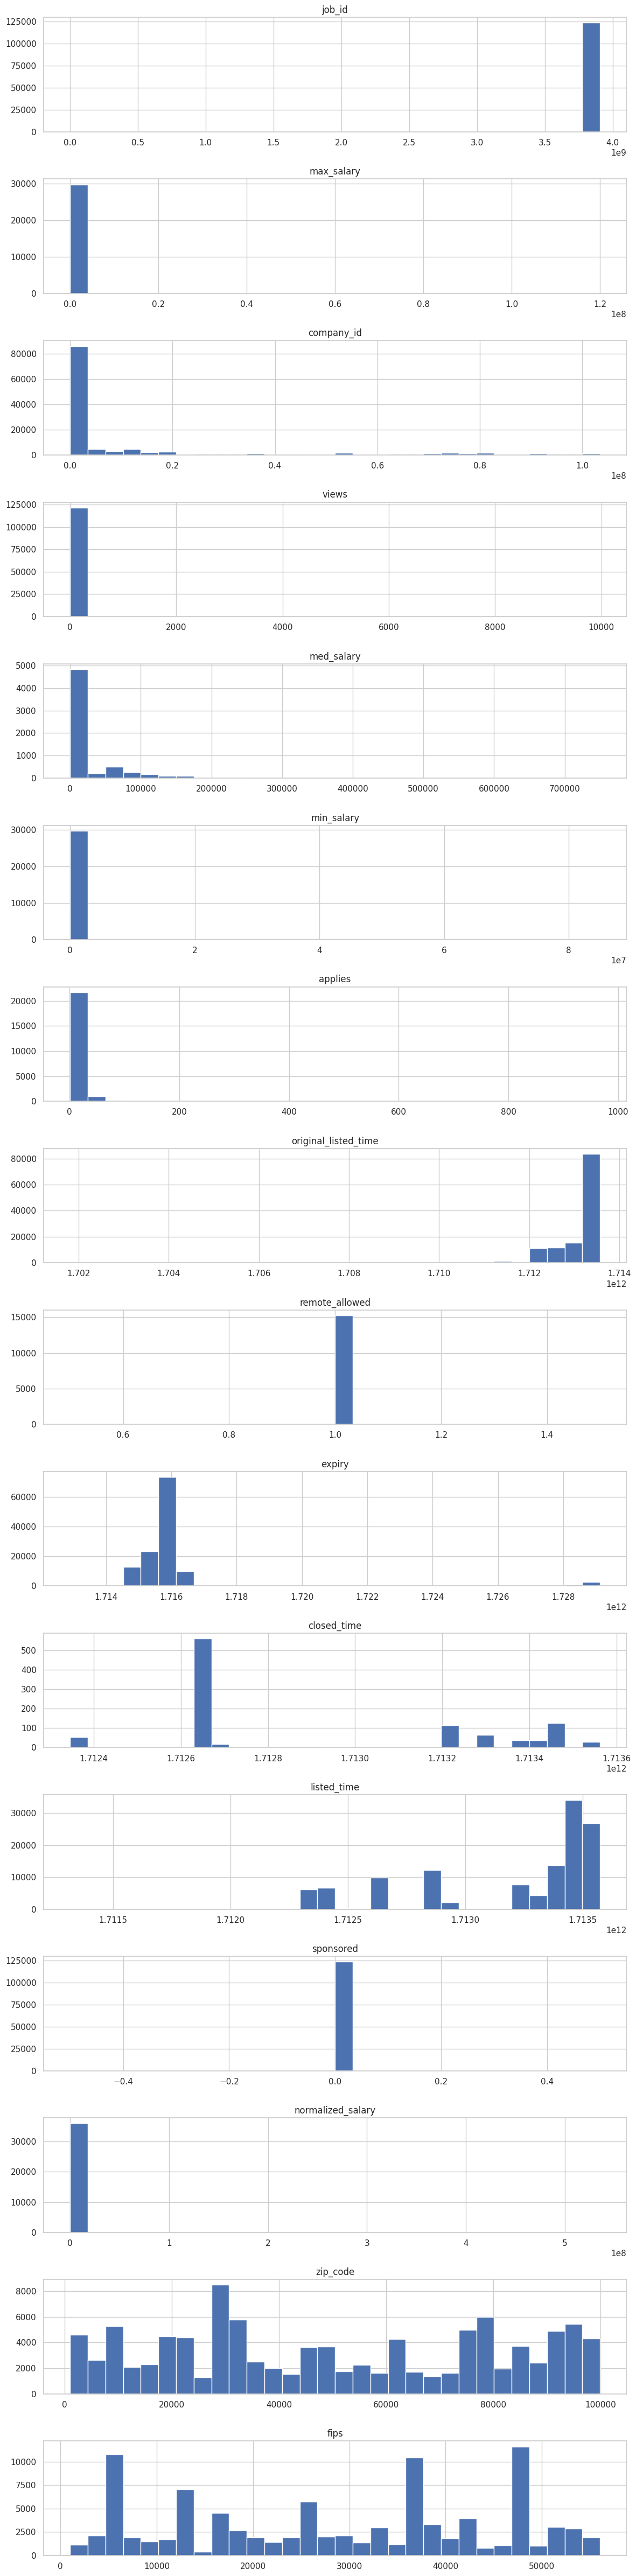

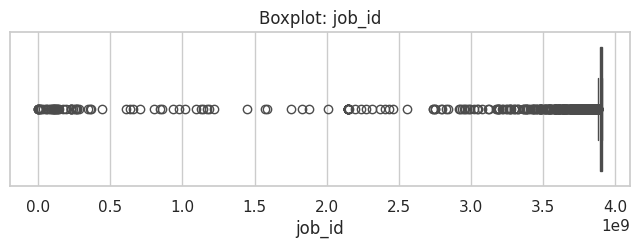

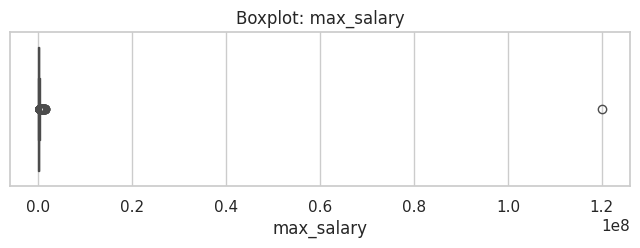

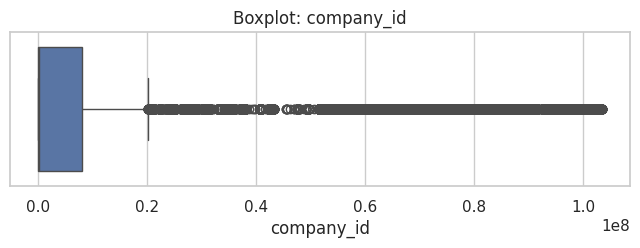

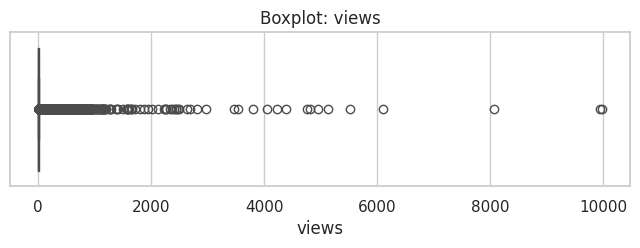

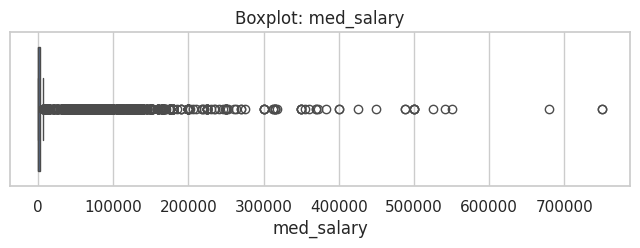

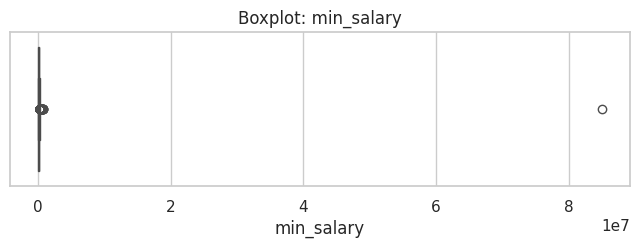

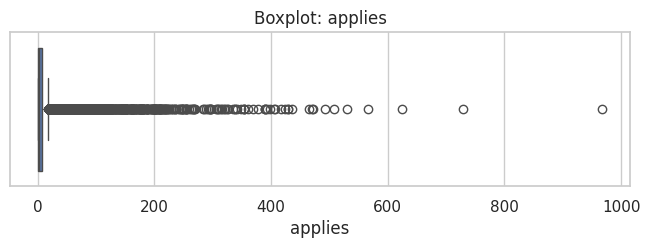

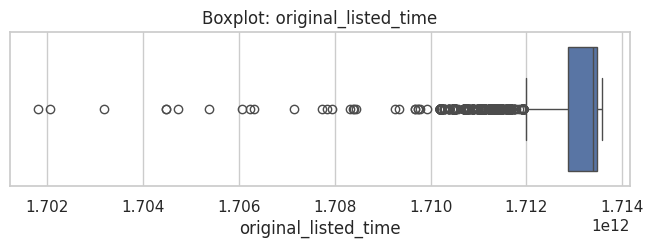

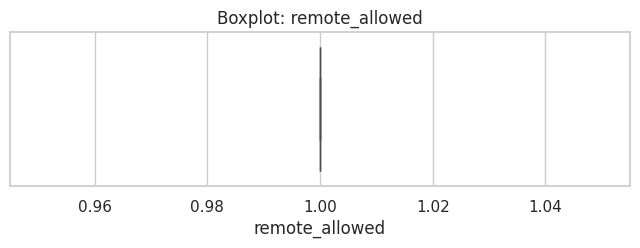

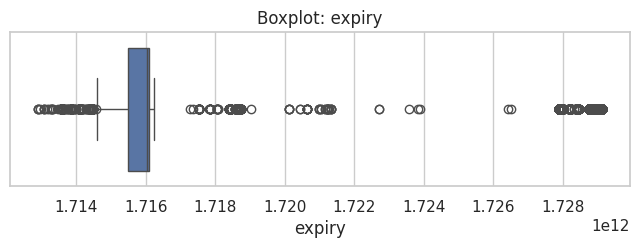

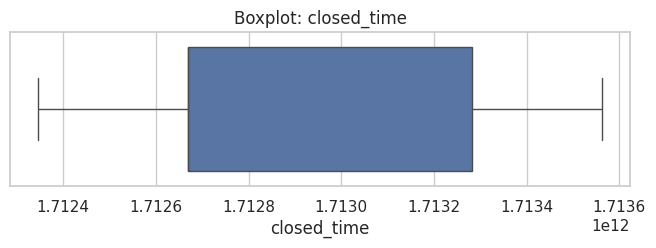

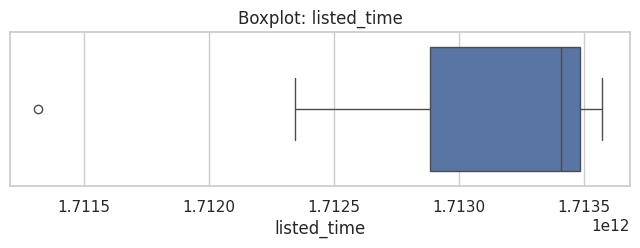

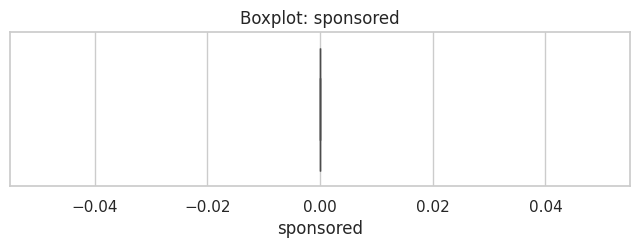

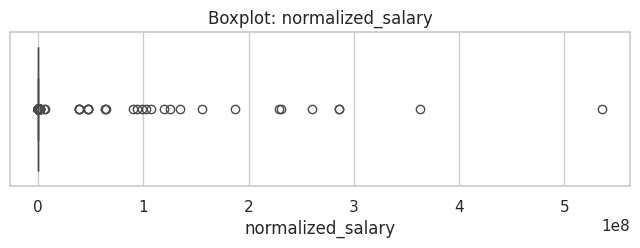

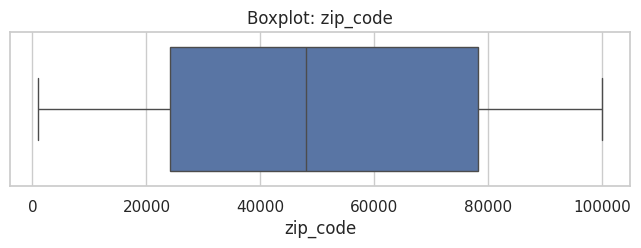

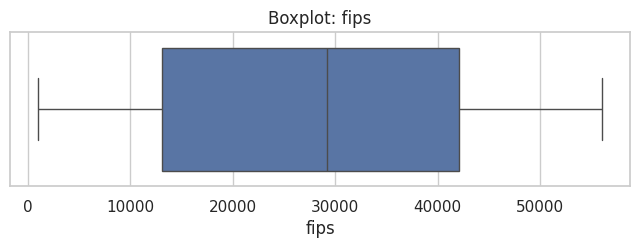

In [9]:
# Plot distributions for numeric columns (histograms + boxplots)
sns.set(style='whitegrid')

num_cols = df_postings.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', num_cols)

if len(num_cols) > 0:
    # Histograms
    df_postings[num_cols].hist(bins=30, figsize=(12, 3*len(num_cols)), layout=(len(num_cols),1))
    plt.tight_layout()

    # Boxplots (one per numeric column)
    for c in num_cols:
        plt.figure(figsize=(8,2))
        sns.boxplot(x=df_postings[c])
        plt.title(f'Boxplot: {c}')
        plt.show()
else:
    print('No numeric columns to plot.')

### Why Use Histograms and Boxplots?

- Histograms
  - What: show the distribution of a single numeric variable by binning values and plotting counts (or density) per bin.
  - What you learn: modality (uni/bi/multi-modal), skewness (left/right), spread, gaps, and approximate density of values.
  - Limitations: results depend on bin width and edges; can hide small numbers of outliers; less precise for comparing multiple groups unless using multiple histograms or normalized densities.

- Boxplots (a.k.a. box-and-whisker)
  - What: show five-number summary (minimum, first quartile Q1, median, third quartile Q3, maximum) and identify outliers beyond the whiskers (commonly 1.5 * IQR).
  - What you learn: central tendency (median), spread (IQR), skew (median vs center of box), and clear identification of outliers.
  - Strengths: compact, robust to binning choices, excellent for side-by-side comparisons across groups or categories.
  - Limitations: does not show modality or detailed shape of the distribution (e.g., bimodality will be hidden).

- Why use both together
  - They complement each other: histogram reveals the full shape (peaks, gaps), while the boxplot highlights summary statistics and outliers.
  - Use histogram to understand the distribution shape and decide if transformations (log, sqrt) are needed; use boxplot to compare spread and detect outliers quickly.

- Practical tips
  - For heavily skewed numeric features, consider plotting the histogram on a log scale or plotting both original and transformed versions.
  - When there are many numeric columns, plot a selected subset or create small multiples (grid) to keep figures readable.
  - Combine with value counts and summary statistics (mean, median, std, IQR, missing%) to make informed preprocessing decisions.

This explanation supplements the histogram and boxplot cells earlier — run those cells to see the visualizations, then refer back here to guide interpretation.

### Correlation Heatmap for Numeric Features

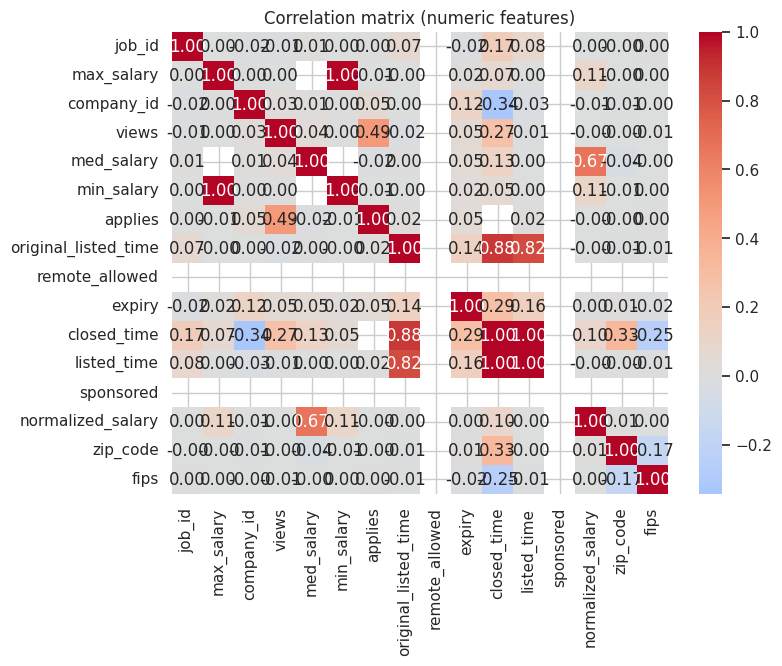

In [10]:
# Correlation matrix and heatmap for numeric features
num_df = df_postings.select_dtypes(include=[np.number])
if not num_df.empty:
    corr = num_df.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Correlation matrix (numeric features)')
    plt.show()
else:
    print('No numeric features to compute correlation.')


### How to Interpret Heatmap

- Correlation values shown in the heatmap are Pearson correlation coefficients which measure linear relationship between two numeric features.
- Range: -1.00 to 1.00
  - Close to 1.00: strong positive linear relationship (as feature A increases, feature B tends to increase).
  - Close to -1.00: strong negative linear relationship (as feature A increases, feature B tends to decrease).
  - Close to 0.00: little or no linear relationship (features appear uncorrelated in a linear sense).

- Practical thresholds (rule-of-thumb):
  - |r| >= 0.7 — strong correlation (watch for multicollinearity if using linear models).
  - 0.3 <= |r| < 0.7 — moderate correlation (may be interesting depending on domain).
  - |r| < 0.3 — weak or negligible linear relationship.

- Important notes:
  - Correlation does not imply causation. A high |r| only indicates association, not a causal link.
  - Pearson correlation only captures linear relationships. Two variables can be strongly related nonlinearly and still show low Pearson r.
  - Outliers can strongly affect correlation values; inspect scatter plots or robust measures if a surprising correlation appears.

Suggested actions when you see strong correlations:
- If two features are highly correlated (|r| >= 0.7), consider removing one, combining them, or using dimensionality reduction (PCA) to avoid multicollinearity in regression-style models.
- For moderate correlations, verify domain relevance before taking action — moderate correlation can be useful predictive information.
- For near-zero correlations, the features may still be useful in non-linear models; don't discard solely on low Pearson r without further checks.


# 3 - Cleaning Data for df_postings

### Merging df_posting with df_salaries

Due to the missing amount of salaries data in df_posting, I merged df_posting with df_salaries to get a more comprehensive view on the salaries of each job posting.
Given the data evaluation above, we will perform the following cleaning:

NaN
- There are almost no columns without missing values
  - company_name : "Unknown"
  - company_id : "Unknown"
  - views : 0
  - Description: ""
  - formatted_experince_level "Unknown"
  - posting_domain: "Unknown"
  - remote_allowed: "Unknown"
  - zip_code: "Unknown"
  - min_salary: 0
  - med_salary: 0
  - max_salary: 0
  - normalized_salary: 0
  - skills_desc: ""
- We should drop these columns because there's not enough info or data
  - application_url
  - pay_period
  - applies
  - close_time
  - currency
  - compensation_type
  - flips



In [11]:
#Replace
df_postings['company_name'] = df_postings['company_name'].fillna("Unknown")
df_postings['company_id'] = df_postings['company_id'].fillna("Unknown")
df_postings['views'] = df_postings['views'].fillna(0)
df_postings['formatted_experience_level'] = df_postings['formatted_experience_level'].fillna("Unknown")
df_postings['description'] = df_postings['description'].fillna("")
df_postings['posting_domain'] = df_postings['posting_domain'].fillna("Unknown")
df_postings['remote_allowed'] = df_postings['remote_allowed'].fillna("Unknown")
df_postings['zip_code'] = df_postings['zip_code'].fillna("Unknown")
df_postings['skills_desc'] = df_postings['skills_desc'].fillna("")
df_postings['applies'] = df_postings['applies'].fillna(0)
df_postings['compensation_type'] = df_postings['views'].fillna("Unknown")

#Drops
columns_to_drop = [
    'application_url',
    'pay_period',
    'applies',
    'closed_time',
    'currency',
    'fips'
]

df_postings = df_postings.drop(columns=[c for c in columns_to_drop if c in df_postings.columns])
df_postings.isna().any()
df_postings['posting_domain'].unique()

array(['Unknown', 'arrowstaffingservices.thejobnetwork.com',
       'williamsleagroupltd.thejobnetwork.com', ..., 'www.opswat.com',
       'imec.csod.com', 'epsoperations.bamboohr.com'], dtype=object)

### Cleaning Data for df_skills
No further cleaning is necessary for df_skills, because it does not contain any NaN. All values appear consistent.

### Abbreviation to full skill definition
job_function_map = {

    'MRKT': 'Marketing',
    'PR': 'Public Relations',
    'WRT': 'Writing',
    'SALE': 'Sales',
    'FIN': 'Finance',
    'ADVR': 'Advertising',
    'BD': 'Business Development',
    'ENG': 'Engineering',
    'PRJM': 'Project Management',
    'IT': 'Information Technology',
    'GENB': 'General Business',
    'ADM': 'Administration',
    'SUPL': 'Supply Chain',
    'MNFC': 'Manufacturing',
    'PROD': 'Product Management',
    'MGMT': 'Management',
    'TRNG': 'Training',
    'OTHR': 'Other',
    'LGL': 'Legal',
    'ACCT': 'Accounting',
    'DSGN': 'Design',
    'RSCH': 'Research',
    'ANLS': 'Analytics',
    'CNSL': 'Consulting',
    'EDU': 'Education',
    'PRCH': 'Purchasing / Procurement',
    'CUST': 'Customer Service',
    'QA': 'Quality Assurance',
    'HR': 'Human Resources',
    'SCI': 'Science',
    'HCPR': 'Healthcare / Patient Care',
    'STRA': 'Strategy',
    'ART': 'Arts / Creative',
    'DIST': 'Distribution / Logistics',
    'PRDM': 'Production Management'
}



In [12]:
df_skills.head()
df_skills['skill_abr'].unique()

array(['MRKT', 'PR', 'WRT', 'SALE', 'FIN', 'ADVR', 'BD', 'ENG', 'PRJM',
       'IT', 'GENB', 'ADM', 'SUPL', 'MNFC', 'PROD', 'MGMT', 'TRNG',
       'OTHR', 'LGL', 'ACCT', 'DSGN', 'RSCH', 'ANLS', 'CNSL', 'EDU',
       'PRCH', 'CUST', 'QA', 'HR', 'SCI', 'HCPR', 'STRA', 'ART', 'DIST',
       'PRDM'], dtype=object)

### Cleaning Data for df_salaries
Removing NaN
- max_salary : 0
- min_salary : 0
if no max_salary or min_salary - remove
med - calucate from max_salary and min_salary

In [13]:
df_salaries = df_salaries.dropna(
    subset=['min_salary', 'max_salary']
)
df_salaries["med_salary"] =  ( df_salaries['min_salary'] + df_salaries['max_salary']) / 2
df_salaries.isna().sum()

,0
salary_id,0
job_id,0
max_salary,0
med_salary,0
min_salary,0
pay_period,0
currency,0
compensation_type,0


### df_benefits & df_industries

These DataFrames contained no missing values.

# 4 - Data Processing

### Encoding the Data

Two of the data sets, df_skills and df_benefits, are made of non-numerical data. To ensure the data is formatted properly for machine learning, we will use a technique called **one-hot encoding** to convert the text into numerical data.

In [14]:
# Get the unique values in the dataframe.
skills = df_skills["skill_abr"].unique()

# Use One-Hot Encoding on the dataframe.
for benefit in skills:
    df_skills[benefit] = df_skills["skill_abr"].apply(lambda x: 1 if benefit in x else 0)

# Drop the original column.
df_skills = df_skills.drop("skill_abr", axis=1)

# Merge all rows with the same job_id.
df_skills = df_skills.groupby("job_id").sum()

df_skills.head()

,MRKT,PR,WRT,SALE,FIN,ADVR,BD,ENG,PRJM,IT,...,PRCH,CUST,QA,HR,SCI,HCPR,STRA,ART,DIST,PRDM
job_id,,,,,,,,,,,,,,,,,,,,,
921716,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218575,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1829192,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2264355,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10998357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Remove rows containing a "0" for a benefit, indicating the benefit is not offered.
mask = df_benefits["inferred"] != 0
df = df_benefits.copy()[mask]

# Get the unique values in the dataframe.
benefits = df["type"].unique()

# Use One-Hot Encoding on the dataframe.
for benefit in benefits:
    df[benefit] = df["type"].apply(lambda x: 1 if benefit in x else 0)

# Drop the original columns.
df = df.drop(["type", "inferred"], axis=1)

# Merge all rows with the same job_id.
df_benefits = df.groupby("job_id").sum()

df_benefits.head()


,401(k),Vision insurance,Disability insurance,Medical insurance,Commuter benefits,Dental insurance,Paid maternity leave,Paid paternity leave,Pension plan,Tuition assistance,Student loan assistance
job_id,,,,,,,,,,,
23221523,1,0,0,0,0,0,0,0,0,0,0
56482768,1,0,1,0,0,1,0,0,0,0,0
95428182,0,0,1,1,0,1,0,0,0,0,0
112576855,0,0,1,1,0,1,0,0,0,0,0
117675818,0,0,0,1,0,0,0,0,0,0,0


### Feature Selection
Some features of the data sets are not useful for our analysis. For example, the salaries data set contains a column for compensation type. However, there is only one unique value in this column. Since it isn't adding any additional information, we will drop it from the data set.

In [16]:
df_salaries = pd.read_csv(salaries_path)
df_salaries = df_salaries.drop('compensation_type', axis=1)

### Scaling

The original salaries data is not usable in its original state, because it compares annual salaries to hourly salaries in the same columns. At a glance, this makes it seem like some companies are severely underpaying. To remedy this and allow for proper comparison, we will convert every salary to be an hourly wage.

In [17]:
salaries_hourly = df_salaries.copy()[df_salaries["pay_period"] == "HOURLY"]
salaries_weekly = df_salaries.copy()[df_salaries["pay_period"] == "WEEKLY"]
salaries_biweekly = df_salaries.copy()[df_salaries["pay_period"] == "BIWEEKLY"]
salaries_monthly = df_salaries.copy()[df_salaries["pay_period"] == "MONTHLY"]
salaries_yearly = df_salaries.copy()[df_salaries["pay_period"] == "YEARLY"]

In [18]:
divisor = 40 # Assumption: An employee will work 40 hours per week.
salaries_weekly["max_salary"] = salaries_weekly["max_salary"] / divisor
salaries_weekly["min_salary"] = salaries_weekly["min_salary"] / divisor
salaries_weekly["med_salary"] = (salaries_weekly['min_salary'] + salaries_weekly['max_salary']) / 2
salaries_weekly.head()

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency
3570,3571,3888020865,40.400,40.400,40.400,WEEKLY,USD
3842,3843,3888028696,53.775,53.775,53.775,WEEKLY,USD
3851,3852,3888031486,52.075,52.075,52.075,WEEKLY,USD
3860,3861,3888032390,50.100,50.100,50.100,WEEKLY,USD
5376,5377,3889188934,67.075,67.075,67.075,WEEKLY,USD


In [19]:
divisor = 80 # Assumption: An employee will work 80 hours every two weeks.
salaries_biweekly["max_salary"] = salaries_biweekly["max_salary"] / divisor
salaries_biweekly["min_salary"] = salaries_biweekly["min_salary"] / divisor
salaries_biweekly["med_salary"] = (salaries_biweekly['min_salary'] + salaries_biweekly['max_salary']) / 2
salaries_biweekly.head()

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency
11759,11760,3895598632,25.7125,25.71250,25.7125,BIWEEKLY,USD
17733,17734,3904387609,837.2000,756.15625,675.1125,BIWEEKLY,USD
18104,18105,3904388204,1124.5625,1008.05000,891.5375,BIWEEKLY,USD
19960,19961,3904386637,26.6750,26.67500,26.6750,BIWEEKLY,USD
21877,21878,3904996213,1017.9250,912.20625,806.4875,BIWEEKLY,USD


In [20]:
divisor = 160 # Assumption: An employee will work 160 hours every month.
salaries_monthly["max_salary"] = salaries_monthly["max_salary"] / divisor
salaries_monthly["min_salary"] = salaries_monthly["min_salary"] / divisor
salaries_monthly["med_salary"] = (salaries_monthly['min_salary'] + salaries_monthly['max_salary']) / 2
salaries_monthly.head()

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency
143,144,3884429616,29.075,26.15625,23.2375,MONTHLY,USD
176,177,3884912836,62.500,47.65625,32.8125,MONTHLY,USD
439,440,3884440251,NaN,NaN,NaN,MONTHLY,USD
467,468,3884435870,NaN,NaN,NaN,MONTHLY,USD
472,473,3884440285,NaN,NaN,NaN,MONTHLY,USD


In [21]:
divisor = 160 * 12 # Assumption: An employee will work 160 hours every month, twelve months a year.
salaries_yearly["max_salary"] = salaries_yearly["max_salary"] / divisor
salaries_yearly["min_salary"] = salaries_yearly["min_salary"] / divisor
salaries_yearly["med_salary"] = (salaries_yearly['min_salary'] + salaries_yearly['max_salary']) / 2
salaries_yearly.head()

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency
2,3,3884431523,62.500000,57.291667,52.083333,YEARLY,USD
3,4,3884911725,104.166667,54.687500,5.208333,YEARLY,USD
6,7,3884915161,41.666667,33.854167,26.041667,YEARLY,USD
7,8,3884428983,52.604167,48.177083,43.750000,YEARLY,USD
9,10,3884429625,52.083333,44.791667,37.500000,YEARLY,USD


In [22]:
# Merge the dataframes back together.
df_salaries = pd.concat([salaries_hourly, salaries_weekly, salaries_biweekly, salaries_monthly, salaries_yearly])
df_salaries = df_salaries.drop('pay_period', axis=1)
df_salaries = df_salaries.dropna()
df_salaries.head()

,salary_id,job_id,max_salary,med_salary,min_salary,currency
3570,3571,3888020865,40.400,40.400,40.400,USD
3842,3843,3888028696,53.775,53.775,53.775,USD
3851,3852,3888031486,52.075,52.075,52.075,USD
3860,3861,3888032390,50.100,50.100,50.100,USD
5376,5377,3889188934,67.075,67.075,67.075,USD


# 5 - K-Means Implementation

### Building the Model

In [46]:
#Skill K-means model
skills = df_skills.copy()

X = skills.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Running KMeans with the value picked from silhouette score
kmeans = KMeans(
    n_clusters=10,
    random_state=42,
    n_init="auto"
)

clusters = kmeans.fit_predict(X_scaled)

In [24]:
#Identifying K, silhouette Score
#Citation: Géron, A. (n.d.-b). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. O’Reilly Online Learning. https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/ch09.html
#Selecting the number of clusters with silhouette analysis on KMeans clustering. (n.d.). Scikit-learn. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# silhouette_scores = []
# for k in range(2,15):
#     kmeans = KMeans(
#         n_clusters=k,
#         random_state=42,
#         n_init="auto"
#     )
#     labels = kmeans.fit_predict(X_scaled)
#     sil = silhouette_score(X_scaled, labels)
#     silhouette_scores.append(sil)

# silhouette_scores

[np.float64(0.2682079188116961),
 np.float64(0.1893809536846097),
 np.float64(0.13315040429907501),
 np.float64(0.2022468800965181),
 np.float64(0.22756246994175805),
 np.float64(0.30932931320437623),
 np.float64(0.37026987413711054),
 np.float64(0.3904768276014164),
 np.float64(0.4143086186165955),
 np.float64(0.41601942444328194),
 np.float64(0.4434342838990148),
 np.float64(0.4757007580825502),
 np.float64(0.48383473743048344)]

### Plotting the Model

X_scaled: (126807, 35)
clusters: (126807,) 126807
X_pca: (126807, 2)


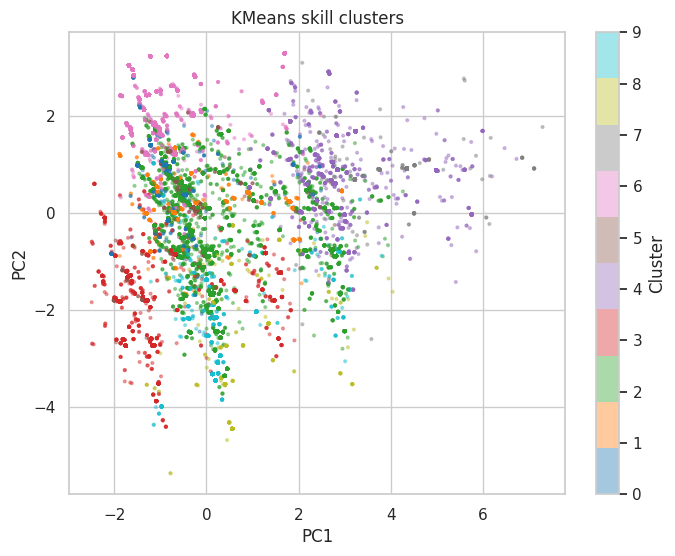

In [47]:
#using PCA to reduce demension
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("X_scaled:", X_scaled.shape)
print("clusters:", clusters.shape, len(clusters))
print("X_pca:", X_pca.shape)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters,
    s=4,
    alpha=0.4,
    cmap="tab10"
)
plt.title("KMeans skill clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

### Skills and Salary Insights

Doc Refrences:
Group By: https://pandas.pydata.org/docs/user_guide/groupby.html

Idxmax: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.

Join: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html

K-means Scikit: https://scikit-learn.org/stable/modules/clustering.html#k-means

In [27]:
skills_clustered = skills.copy()
#cluster labels
skills_clustered["cluster"] = clusters

#Adding the medium salary as a feature to our clustered skills, joining by the job_id
df = skills_clustered.join(
    df_salaries
        .set_index("job_id")[["med_salary"]],
    how="inner"
)
#Grouping by the common medimum lalaries (thank you SQL skills)
cluster_salary = (
    df
        .groupby("cluster")["med_salary"]
        .mean()
        .sort_values(ascending=False)
)
#Medium salary for each cluster
cluster_salary


,med_salary
cluster,
5,86.448101
6,71.901578
4,69.606485
9,69.562145
2,64.070454
8,60.151279
0,53.772827
1,53.730502
7,53.441699


In [28]:
skill_cols = df_skills.columns
#Skill frequency within each cluster
cluster_skill_means = (
    df
        .groupby("cluster")[skill_cols]
        .mean()
)

#Top 3 clusters with the highest and lowest average salary
high_clusters = cluster_salary.head(3).index
low_clusters  = cluster_salary.tail(3).index
#So skills can appear clusters with high or low salaries
#for each skill, take how often it appears in high-paying clusters and subtract it from how often it appears in low paying clusters
skill_diff = (
    cluster_skill_means.loc[high_clusters].mean()
    - cluster_skill_means.loc[low_clusters].mean()
).sort_values(ascending=False)
#Leaves us with what percent more often a skill is in a high paying job then a low paying job
skill_diff.head(15)


,0
LGL,0.331169
SALE,0.316396
BD,0.218490
HCPR,0.184932
MRKT,0.101016
PRDM,0.059643
FIN,0.053321
PRJM,0.040628
WRT,0.036894
CUST,0.012024


In [29]:
#Mapping the kill to it's abbrivation to make it easier to read
job_function_map = {

    'MRKT': 'Marketing',
    'PR': 'Public Relations',
    'WRT': 'Writing',
    'SALE': 'Sales',
    'FIN': 'Finance',
    'ADVR': 'Advertising',
    'BD': 'Business Development',
    'ENG': 'Engineering',
    'PRJM': 'Project Management',
    'IT': 'Information Technology',
    'GENB': 'General Business',
    'ADM': 'Administration',
    'SUPL': 'Supply Chain',
    'MNFC': 'Manufacturing',
    'PROD': 'Product Management',
    'MGMT': 'Management',
    'TRNG': 'Training',
    'OTHR': 'Other',
    'LGL': 'Legal',
    'ACCT': 'Accounting',
    'DSGN': 'Design',
    'RSCH': 'Research',
    'ANLS': 'Analytics',
    'CNSL': 'Consulting',
    'EDU': 'Education',
    'PRCH': 'Purchasing / Procurement',
    'CUST': 'Customer Service',
    'QA': 'Quality Assurance',
    'HR': 'Human Resources',
    'SCI': 'Science',
    'HCPR': 'Healthcare / Patient Care',
    'STRA': 'Strategy',
    'ART': 'Arts / Creative',
    'DIST': 'Distribution / Logistics',
    'PRDM': 'Production Management'
}
skill_diff_df = skill_diff.reset_index()
skill_diff_df.columns = ["skill_code", "difference"]
skill_diff_df["skill_name"] = skill_diff_df["skill_code"].map(job_function_map)
skill_diff_df["difference"] = skill_diff_df["difference"] * 100
skill_diff_df

,skill_code,difference,skill_name
0,LGL,33.116883,Legal
1,SALE,31.639588,Sales
2,BD,21.848967,Business Development
3,HCPR,18.493209,Healthcare / Patient Care
4,MRKT,10.101591,Marketing
5,PRDM,5.964253,Production Management
6,FIN,5.332059,Finance
7,PRJM,4.062830,Project Management
8,WRT,3.689370,Writing
9,CUST,1.202447,Customer Service


### Skill-to-Salary Insights
Research, Legal, Sales, Business Development, and Analysis appear more frequently in higher-paying job clusters compared to lower-paying clusters, indicating a strong association with higher-paying roles.

Skills with minimal or 0 differences show little distinction between higher- and lower-paying clusters.

Public Relations, Purchasing, Manufacturing, Human Resources and Management are associated with lower paying roles and are assoicated with lower paying clusters


### Skill-to-Location Insights

In [30]:
#isolationg location and job id
post_loc = (
    df_postings[["job_id", "location"]]
        .drop_duplicates(subset="job_id")
)

#joining the dataframes to get location
post_loc = post_loc.set_index("job_id")
df_with_loc = df.join(post_loc, how="left")

#grouping by location and finding the frequency of each skill
location_skill_means = (
    df_with_loc
        .groupby("location")[skill_cols]
        .mean()
)
#idxmax returns largest column value in each row
# adding axis=1 param will look at columns instead of rows.
top_skill_per_location = location_skill_means.idxmax(axis=1)
print(top_skill_per_location)

print(" ")
print("Top Skills in top tech marchets")
print("Seattle, WA:", top_skill_per_location["Seattle, WA"])
print("San Francisco, CA:", top_skill_per_location["San Francisco, CA"])
print("San Jose, CA:", top_skill_per_location["San Jose, CA"])
print("New York, NY:", top_skill_per_location["New York, NY"])
print("Austin, TX:", top_skill_per_location["Austin, TX"])



location
Aberdeen Proving Ground, MD      IT
Aberdeen, MD                    ENG
Aberdeen, WA                   OTHR
Abilene, TX                    SALE
Abingdon, MD                   MRKT
                               ... 
Yuba City, CA                    PR
Yuba County, CA                RSCH
Yuma, AZ                         QA
Zelienople, PA                  FIN
Zionsville, IN                  ENG
Length: 2762, dtype: object
 
Top Skills in top tech marchets
Seattle, WA: IT
San Francisco, CA: SALE
San Jose, CA: IT
New York, NY: SALE
Austin, TX: IT


In [ ]:
# looking at the top 10 skills in a specific market
location_skill_means.loc["Seattle, WA"].sort_values(ascending=False).head(10)


# 6 - Hierarchical Clustering Implementation

### Building the Model

In [31]:
# Get the median salaries.
df_med_salaries = df_salaries[['job_id', 'med_salary']]
df_med_salaries.head()

,job_id,med_salary
3570,3888020865,40.400
3842,3888028696,53.775
3851,3888031486,52.075
3860,3888032390,50.100
5376,3889188934,67.075


In [32]:
# Get the total benefits offered by each job.
sum_benefits = df_benefits.iloc[:, 1:].sum(axis=1)
sum_benefits.name = "benefits"
sum_benefits.head()

,benefits
job_id,
23221523,0
56482768,2
95428182,3
112576855,3
117675818,1


In [33]:
X = pd.merge(df_med_salaries, sum_benefits, on='job_id')
X_scaled = scaler.fit_transform(X)

agg_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
labels = agg_model.fit_predict(X_scaled)

### Plotting the Model

In [34]:
# Plots a dendrogram for a given model.
def plot_dendrogram(model, num_levels=4):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, truncate_mode='level', p=num_levels)

# Plots the Agglomerative Clustering diagram.
def plot_hierarchical_clusters(model):
    plot_dendrogram(model)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Points In Node")
    plt.ylabel("Distance")
    plt.show()

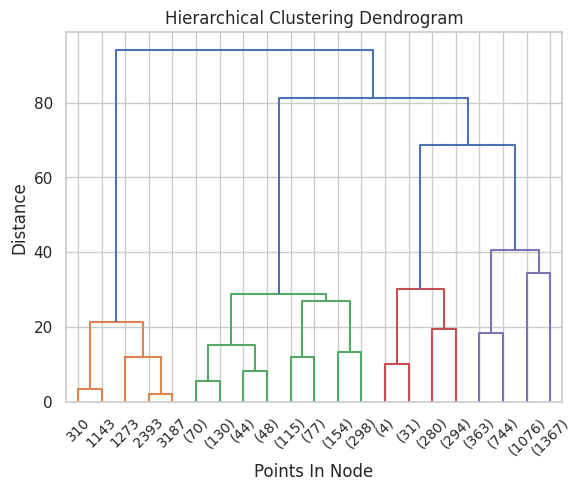

In [35]:
plot_hierarchical_clusters(agg_model)

### Evaluating the Model

In [36]:
n_clusters = agg_model.n_clusters_

print("Model Labels:", labels)
print("Estimated Number of Clusters:", n_clusters)

Model Labels: [3228 3773 3186 ...    1    2    0]
Estimated Number of Clusters: 5100


### Model Insights

In [37]:
# Calculate the linkage matrix.
linked = linkage(X_scaled, method='ward')

# Using the dendogram, establish the distance threshold.
# I selected a distance of 50.
threshold_distance = 50

# Get the cluster labels.
cluster_labels = fcluster(linked, threshold_distance, criterion='distance')

# Add the cluster labels to the dataframe.
X['cluster'] = cluster_labels

In [38]:
X.head()

,job_id,med_salary,benefits,cluster
0,3888020865,40.400,1,4
1,3889188934,67.075,1,4
2,3889191446,45.425,1,4
3,3889191542,51.657,3,2
4,3889194326,101.225,0,3


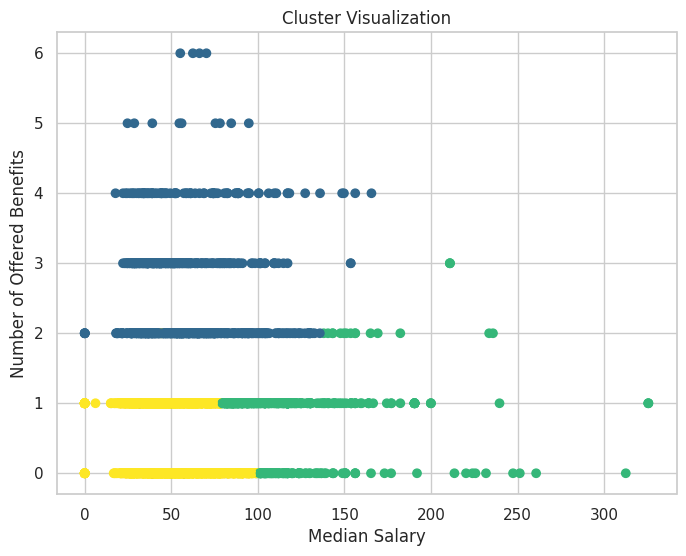

In [39]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(X['med_salary'], X['benefits'], c=X['cluster'], cmap='viridis')
plt.xlabel('Median Salary')
plt.ylabel('Number of Offered Benefits')
plt.title('Cluster Visualization')
plt.show()